Found 2410 files belonging to 4 classes.
Found 275 files belonging to 4 classes.
Classes: ['Healthy', 'Miner', 'Phoma', 'Rust']


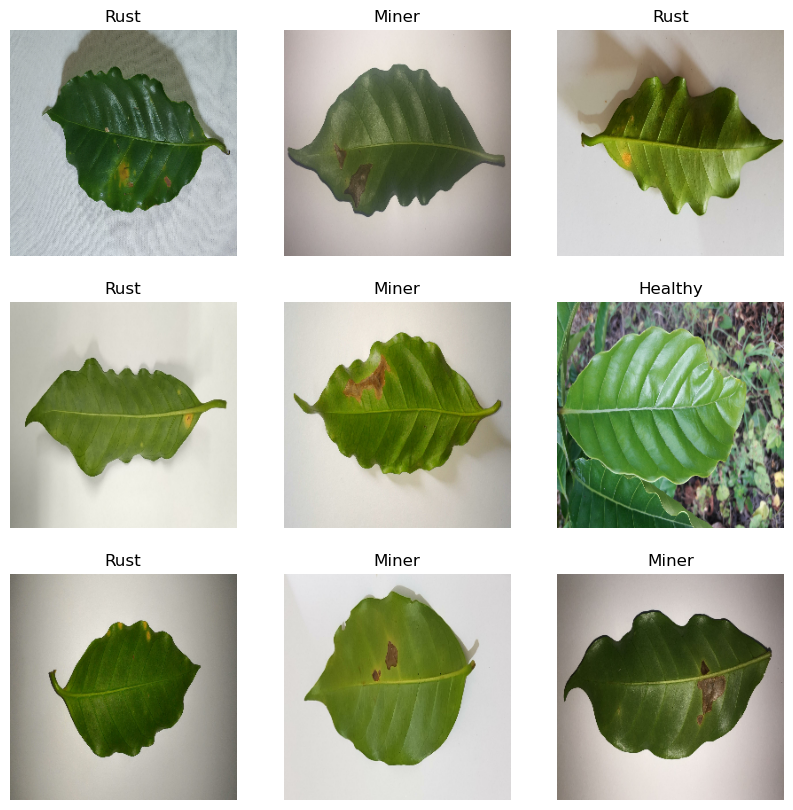

In [1]:
%run data_exploration.ipynb

#### Train / Validation Split

In [2]:
def split_train_validation(dataset, train_split=0.8, val_split=0.1):
    size = len(dataset)
    train_size = int(train_split * size)
    val_size = int(val_split * size)

    dataset = dataset.shuffle(10000, seed=12)

    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)

    return train_ds, val_ds

train_ds, val_ds = split_train_validation(train_ds)


#### Dataset Optimization

In [3]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

#### Build Model

In [4]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    layers.Rescaling(1./255),

    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(len(class_names), activation='softmax')
])



In [5]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,743,044 (14.28 MB)

 Trainable params: 3,743,044 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

#### Callbacks

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath='models/best_coffee_leaf_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

#### Train Model

In [7]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, callbacks=[early_stopping, checkpoint])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3678 - loss: 1.6007
Epoch 1: val_accuracy improved from None to 0.49479, saving model to models/best_coffee_leaf_model.keras

Epoch 1: finished saving model to models/best_coffee_leaf_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.3841 - loss: 1.2902 - val_accuracy: 0.4948 - val_loss: 0.9764
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4211 - loss: 1.0775
Epoch 2: val_accuracy did not improve from 0.49479
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4336 - loss: 1.0656 - val_accuracy: 0.4844 - val_loss: 0.9715
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4214 - loss: 1.0605
Epoch 3: val_accuracy improved from 0.49479 to 0.52083, saving model to models/best_coffee_leaf_model.keras

Epoch 3: finished saving model to models/best_coffee_leaf_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4294 - loss: 1.0516 - val_accuracy: 0.5208 - val_loss: 0.9635


#### Load Best Model

In [9]:
best_model = tf.keras.models.load_model('models/best_coffee_leaf_model.keras')

#### Evaluation on Test Set

In [10]:
test_loss, test_accuracy = best_model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - accuracy: 0.8509 - loss: 0.5309
Test Accuracy: 0.8509


#### Confusion Matrix + Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
              precision    recall  f1-score   support

     Healthy       0.75      0.95      0.84        83
       Miner       0.71      0.92      0.80        26
       Phoma       1.00      0.77      0.87       145
        Rust       0.80      0.95      0.87        21

    accuracy                           0.85       275
   macro avg       0.81      0.90      0.84       275
weighted avg       0.88      0.85      0.85       275



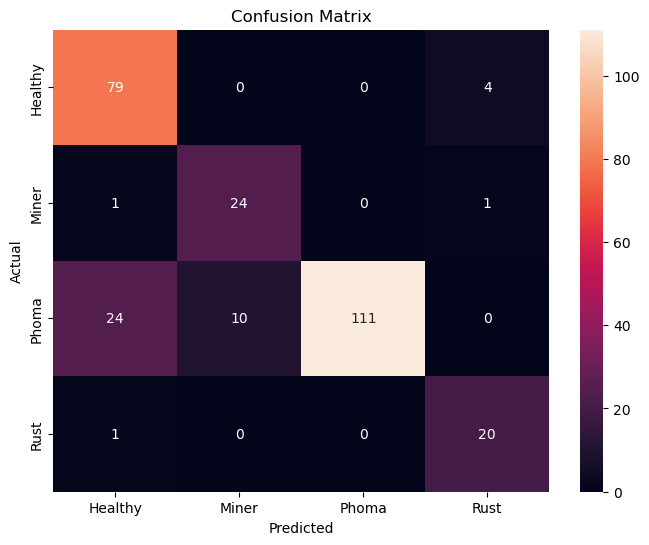

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix


y_true, y_pred = [], []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### Accuracy & Loss Curves

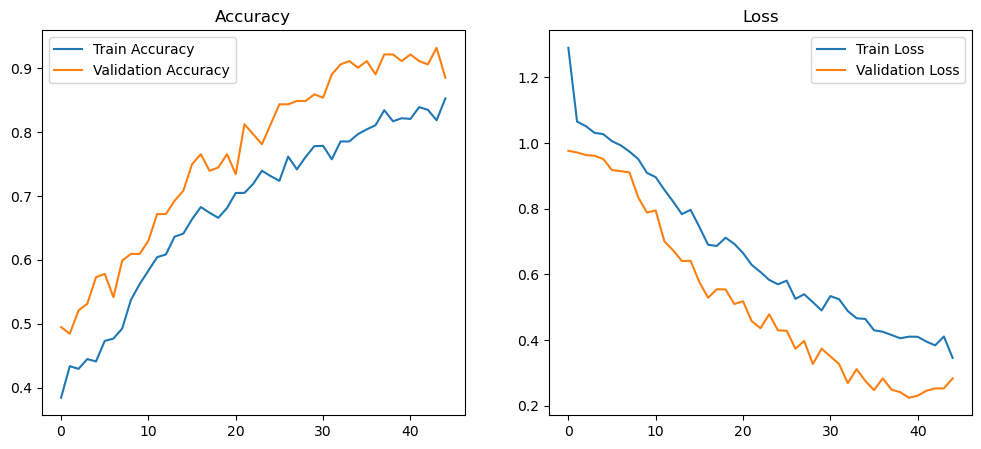

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()
